Independent RF Models RMSE:
FSO RMSE: 0.8983
RFL RMSE: 0.5221

Joint RF Model RMSE:
FSO RMSE: 0.9386
RFL RMSE: 0.4982

Sequential RF Models RMSE:
FSO RMSE: 0.9232

Neural Network Model RMSE:
FSO RMSE: 1.2678
RFL RMSE: 0.7185

Weather-Specific Models RMSE:
SYNOP 0 RMSE: 0.9156
SYNOP 6 RMSE: 0.9167
SYNOP 8 RMSE: 1.0410
SYNOP 5 RMSE: 1.0121
SYNOP 3 RMSE: 2.6160
SYNOP 4 RMSE: 0.7806
SYNOP 7 RMSE: 0.9873


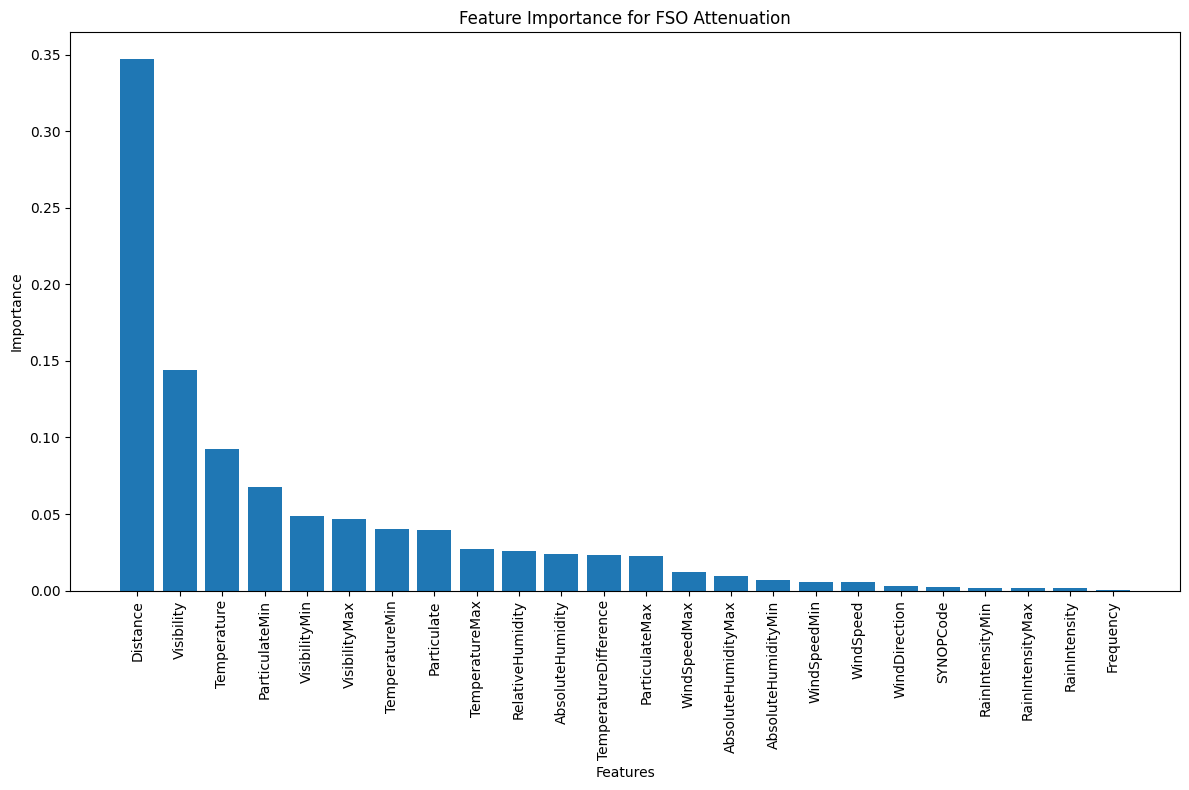

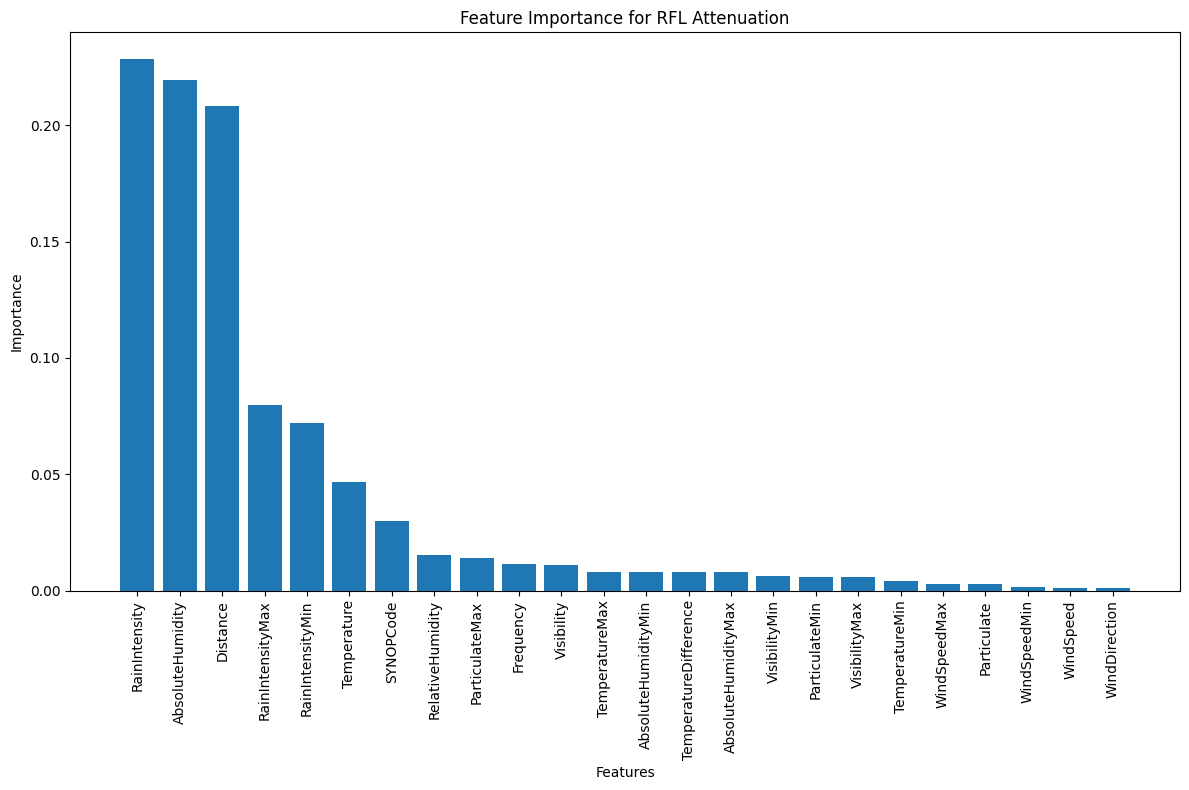

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('/kaggle/input/hybrid-opticalradio-f/RFLFSODataFull (1).csv')

# Preprocessing
data = data.drop(['Time'], axis=1)
X = data.drop(columns=['FSO_Att', 'RFL_Att'])
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

# Split the data
X_train, X_test, y_fso_train, y_fso_test, y_rfl_train, y_rfl_test = train_test_split(
    X, y_fso, y_rfl, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Independent Random Forest Models
rf_fso = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rfl = RandomForestRegressor(n_estimators=100, random_state=42)

rf_fso.fit(X_train_scaled, y_fso_train)
rf_rfl.fit(X_train_scaled, y_rfl_train)

y_fso_pred = rf_fso.predict(X_test_scaled)
y_rfl_pred = rf_rfl.predict(X_test_scaled)

fso_rmse = np.sqrt(mean_squared_error(y_fso_test, y_fso_pred))
rfl_rmse = np.sqrt(mean_squared_error(y_rfl_test, y_rfl_pred))

print("Independent RF Models RMSE:")
print(f"FSO RMSE: {fso_rmse:.4f}")
print(f"RFL RMSE: {rfl_rmse:.4f}")

# 2. Joint Random Forest Model
y_joint = np.column_stack((y_fso, y_rfl))
y_joint_train, y_joint_test = train_test_split(y_joint, test_size=0.2, random_state=42)

rf_joint = RandomForestRegressor(n_estimators=100, random_state=42)
rf_joint.fit(X_train_scaled, y_joint_train)

y_joint_pred = rf_joint.predict(X_test_scaled)

joint_fso_rmse = np.sqrt(mean_squared_error(y_joint_test[:, 0], y_joint_pred[:, 0]))
joint_rfl_rmse = np.sqrt(mean_squared_error(y_joint_test[:, 1], y_joint_pred[:, 1]))

print("\nJoint RF Model RMSE:")
print(f"FSO RMSE: {joint_fso_rmse:.4f}")
print(f"RFL RMSE: {joint_rfl_rmse:.4f}")

# 3. Sequential Random Forest Models
rf_rfl_seq = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rfl_seq.fit(X_train_scaled, y_rfl_train)

rfl_pred_train = rf_rfl_seq.predict(X_train_scaled)
rfl_pred_test = rf_rfl_seq.predict(X_test_scaled)

X_train_seq = np.column_stack((X_train_scaled, rfl_pred_train))
X_test_seq = np.column_stack((X_test_scaled, rfl_pred_test))

rf_fso_seq = RandomForestRegressor(n_estimators=100, random_state=42)
rf_fso_seq.fit(X_train_seq, y_fso_train)

y_fso_seq_pred = rf_fso_seq.predict(X_test_seq)

seq_fso_rmse = np.sqrt(mean_squared_error(y_fso_test, y_fso_seq_pred))

print("\nSequential RF Models RMSE:")
print(f"FSO RMSE: {seq_fso_rmse:.4f}")

# 4. Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_joint_train)

y_nn_pred = nn_model.predict(X_test_scaled)

nn_fso_rmse = np.sqrt(mean_squared_error(y_joint_test[:, 0], y_nn_pred[:, 0]))
nn_rfl_rmse = np.sqrt(mean_squared_error(y_joint_test[:, 1], y_nn_pred[:, 1]))

print("\nNeural Network Model RMSE:")
print(f"FSO RMSE: {nn_fso_rmse:.4f}")
print(f"RFL RMSE: {nn_rfl_rmse:.4f}")

# 5. Weather-Specific Models
weather_models = {}
weather_rmse = {}

for synop in data['SYNOPCode'].unique():
    mask = data['SYNOPCode'] == synop
    X_weather = X[mask].drop('SYNOPCode', axis=1)
    y_fso_weather = y_fso[mask]
    y_rfl_weather = y_rfl[mask]
    
    X_train_w, X_test_w, y_fso_train_w, y_fso_test_w, y_rfl_train_w, y_rfl_test_w = train_test_split(
        X_weather, y_fso_weather, y_rfl_weather, test_size=0.2, random_state=42)
    
    scaler_w = StandardScaler()
    X_train_w_scaled = scaler_w.fit_transform(X_train_w)
    X_test_w_scaled = scaler_w.transform(X_test_w)
    
    rf_weather = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_weather.fit(X_train_w_scaled, y_fso_train_w)
    
    y_fso_pred_w = rf_weather.predict(X_test_w_scaled)
    
    weather_models[synop] = rf_weather
    weather_rmse[synop] = np.sqrt(mean_squared_error(y_fso_test_w, y_fso_pred_w))

print("\nWeather-Specific Models RMSE:")
for synop, rmse in weather_rmse.items():
    print(f"SYNOP {synop} RMSE: {rmse:.4f}")

# Feature Importance and Visualization
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance for FSO model
plot_feature_importance(rf_fso, X.columns, "Feature Importance for FSO Attenuation")

# Plot feature importance for RFL model
plot_feature_importance(rf_rfl, X.columns, "Feature Importance for RFL Attenuation")

# RMSE and R-squared values visualization
def plot_metrics(model, X, y, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    rmse_values = []
    r2_values = []
    
    for i in range(1, len(feature_names) + 1):
        selected_features = [feature_names[j] for j in indices[:i]]
        X_selected = X[selected_features]
        
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        rmse_values.append(rmse)
        r2_values.append(r2)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.plot(range(1, len(feature_names) + 1), rmse_values, 'b-')
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('RMSE', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(feature_names) + 1), r2_values, 'r-')
    ax2.set_ylabel('R-squared', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title(title)
    plt.axvline(x=len(feature_names)//2, color='g', linestyle='--')
    plt.tight_layout()
    plt.show()

# Plot metrics for FSO model
plot_metrics(rf_fso, X, y_fso, X.columns, "RMSE and R-squared vs Number of Features (FSO)")

# Plot metrics for RFL model
plot_metrics(rf_rfl, X, y_rfl, X.columns, "RMSE and R-squared vs Number of Features (RFL)")

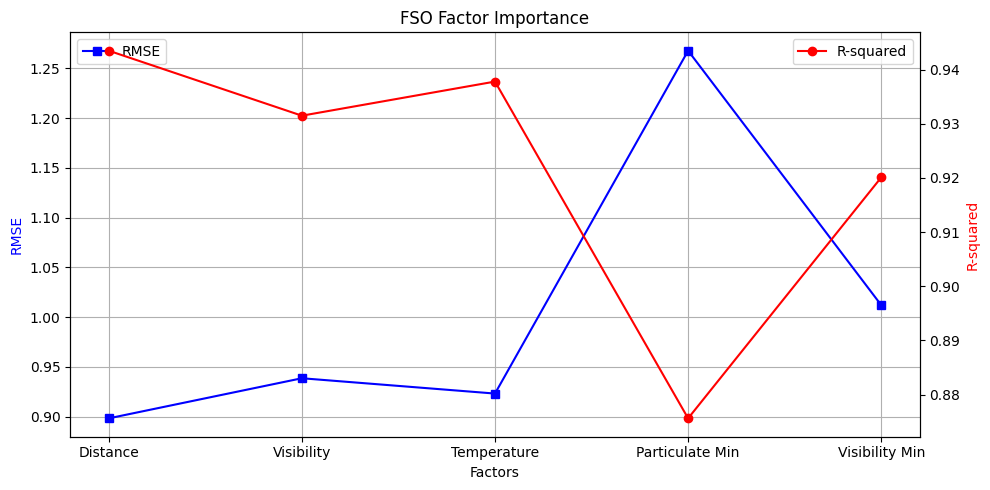

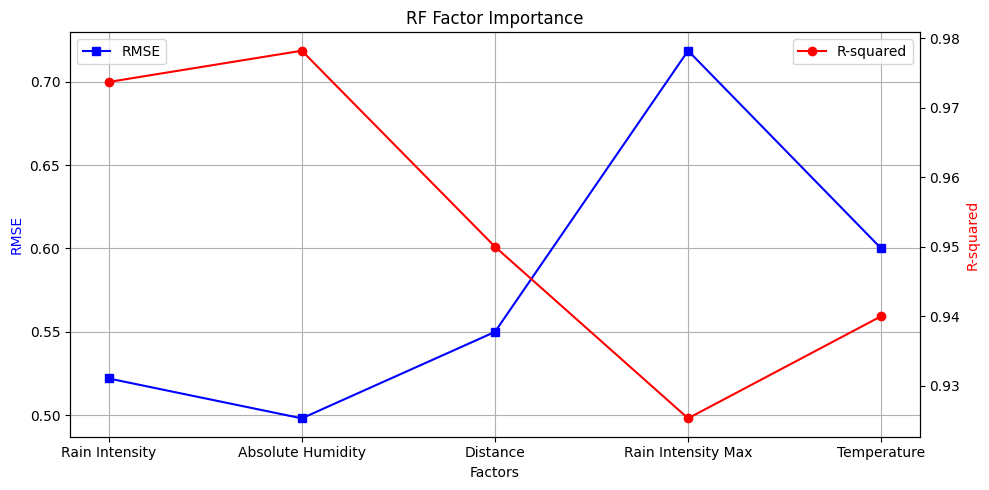

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Factors for FSO
fso_factors = ['Distance', 'Visibility', 'Temperature', 'Particulate Min', 'Visibility Min']
fso_r_squared = [0.9435, 0.9315, 0.9378, 0.8756, 0.9201]
fso_rmse = [0.8983, 0.9386, 0.9232, 1.2678, 1.0121]

# Factors for RF
rf_factors = ['Rain Intensity', 'Absolute Humidity', 'Distance', 'Rain Intensity Max', 'Temperature']
rf_r_squared = [0.9737, 0.9782, 0.9500, 0.9253, 0.9400]
rf_rmse = [0.5221, 0.4982, 0.5500, 0.7185, 0.6000]

# FSO plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(fso_factors, fso_rmse, marker='s', color='b', label='RMSE')
ax2.plot(fso_factors, fso_r_squared, marker='o', color='r', label='R-squared')
ax1.set_title('FSO Factor Importance')
ax1.set_xlabel('Factors')
ax1.set_ylabel('RMSE', color='b')
ax2.set_ylabel('R-squared', color='r')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.tight_layout()
plt.savefig('fso_factor_importance.png')
plt.show()

# RF plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(rf_factors, rf_rmse, marker='s', color='b', label='RMSE')
ax2.plot(rf_factors, rf_r_squared, marker='o', color='r', label='R-squared')
ax1.set_title('RF Factor Importance')
ax1.set_xlabel('Factors')
ax1.set_ylabel('RMSE', color='b')
ax2.set_ylabel('R-squared', color='r')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
plt.tight_layout()
plt.savefig('rf_factor_importance.png')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    KFold,
    learning_curve
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class RFFSOAnalyzer:
    def __init__(self, data_path):
        self.data = pd.read_csv('/kaggle/input/hybrid-opticalradio-f/RFLFSODataFull (1).csv')
        self.preprocessed = False
        
    def preprocess_data(self):
        """Enhanced preprocessing with outlier detection and handling"""
        # Drop unnecessary columns and handle missing values
        self.data = self.data.drop(['Time'], axis=1)
        
        # Outlier detection using Z-score
        def remove_outliers(df, columns, z_threshold=3):
            for col in columns:
                z_scores = stats.zscore(df[col])
                df = df[abs(z_scores) < z_threshold]
            return df
            
        numerical_cols = self.data.select_dtypes(include=[np.number]).columns
        self.data = remove_outliers(self.data, numerical_cols)
        
        # Split features and targets
        self.X = self.data.drop(columns=['FSO_Att', 'RFL_Att'])
        self.y_fso = self.data['FSO_Att']
        self.y_rfl = self.data['RFL_Att']
        
        # Feature scaling
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.preprocessed = True
        
    def optimize_hyperparameters(self):
        """Hyperparameter optimization using GridSearchCV"""
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        models = {
            'FSO': RandomForestRegressor(random_state=42),
            'RFL': RandomForestRegressor(random_state=42)
        }
        
        optimized_models = {}
        
        for name, model in models.items():
            grid_search = GridSearchCV(
                model, param_grid, cv=5, 
                scoring='neg_root_mean_squared_error',
                n_jobs=-1
            )
            
            if name == 'FSO':
                grid_search.fit(self.X_scaled, self.y_fso)
            else:
                grid_search.fit(self.X_scaled, self.y_rfl)
                
            optimized_models[name] = grid_search.best_estimator_
            print(f"\nBest parameters for {name}:")
            print(grid_search.best_params_)
            
        return optimized_models
    
    def plot_learning_curves(self, model, X, y, title):
        """Generate learning curves to analyze model performance"""
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, 
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=5, n_jobs=-1, 
            scoring='neg_root_mean_squared_error'
        )
        
        train_mean = -np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = -np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score')
        plt.fill_between(train_sizes, train_mean - train_std, 
                        train_mean + train_std, alpha=0.1)
        plt.plot(train_sizes, val_mean, label='Cross-validation score')
        plt.fill_between(train_sizes, val_mean - val_std,
                        val_mean + val_std, alpha=0.1)
        plt.xlabel('Training Examples')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
    def analyze_weather_impact(self):
        """Analyze impact of different weather conditions"""
        weather_conditions = self.data['SYNOPCode'].unique()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        for condition in weather_conditions:
            condition_data = self.data[self.data['SYNOPCode'] == condition]
            
            # Plot FSO attenuation
            ax1.scatter(condition_data['Visibility'], 
                       condition_data['FSO_Att'],
                       alpha=0.5,
                       label=f'SYNOP {condition}')
            
            # Plot RF attenuation
            ax2.scatter(condition_data['Rain_Intensity'],
                       condition_data['RFL_Att'],
                       alpha=0.5,
                       label=f'SYNOP {condition}')
        
        ax1.set_xlabel('Visibility')
        ax1.set_ylabel('FSO Attenuation')
        ax1.set_title('FSO Attenuation vs Visibility by Weather Condition')
        ax1.legend()
        ax1.grid(True)
        
        ax2.set_xlabel('Rain Intensity')
        ax2.set_ylabel('RF Attenuation')
        ax2.set_title('RF Attenuation vs Rain Intensity by Weather Condition')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    def correlation_analysis(self):
        """Enhanced correlation analysis with feature interactions"""
        # Calculate correlation matrix
        corr_matrix = self.data.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        # Analyze feature interactions
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        # FSO interactions
        sns.scatterplot(data=self.data, x='Visibility', y='FSO_Att',
                       hue='Temperature', ax=axes[0,0])
        axes[0,0].set_title('FSO Attenuation vs Visibility (Temperature)')
        
        sns.scatterplot(data=self.data, x='Particulate_Min', y='FSO_Att',
                       hue='Visibility_Min', ax=axes[0,1])
        axes[0,1].set_title('FSO Attenuation vs Particulate (Visibility)')
        
        # RF interactions
        sns.scatterplot(data=self.data, x='Rain_Intensity', y='RFL_Att',
                       hue='Absolute_Humidity', ax=axes[1,0])
        axes[1,0].set_title('RF Attenuation vs Rain Intensity (Humidity)')
        
        sns.scatterplot(data=self.data, x='Temperature', y='RFL_Att',
                       hue='Rain_Intensity_Max', ax=axes[1,1])
        axes[1,1].set_title('RF Attenuation vs Temperature (Rain Max)')
        
        plt.tight_layout()
        plt.show()

analyzer = RFFSOAnalyzer('/kaggle/input/hybrid-opticalradio-f/RFLFSODataFull (1).csv')
analyzer.preprocess_data()
optimized_models = analyzer.optimize_hyperparameters()

# Generate various analyses
analyzer.plot_learning_curves(optimized_models['FSO'], 
                            analyzer.X_scaled, 
                            analyzer.y_fso, 
                            'FSO Model')
analyzer.plot_learning_curves(optimized_models['RFL'], 
                            analyzer.X_scaled, 
                            analyzer.y_rfl, 
                            'RF Model')
analyzer.analyze_weather_impact()
analyzer.correlation_analysis()